# Train PointNet (https://arxiv.org/abs/1612.00593).

This notebook shows you how to use the PreprocessedDataGenerator in order to train PointNet.

The PreprocessedDataGenerator uses preprocessed-data instead of ETL-data. Wheras ETL-data comes mainly as PCD-files, preprocessed-data comes mainly as pointclouds stored as numpy-arrays. We identified PCD-loading as a bottleneck. 

In [1]:
import sys
sys.path.insert(0, "..")

import numpy as np
import os
import random

# Get the dataset path.

This snippet shows you how to get the lates preprocessed path.

In [2]:
from cgmcore.preprocesseddatagenerator import get_dataset_path

dataset_path = get_dataset_path("../../data/preprocessed")
print("Using dataset path", dataset_path)

WARNING! VTK not available. This might limit the functionality.
Using dataset path ../../data/preprocessed/2018_07_31_10_52


# Hyperparameters.

In [3]:
steps_per_epoch = 10
validation_steps = 10
epochs = 4
batch_size = 1
random_seed = 667

# Create data-generator.

The method create_datagenerator_from_parameters is a convencience method. It allows you to instantiate a generator from a specification-dictionary.

In [4]:
from cgmcore.preprocesseddatagenerator import create_datagenerator_from_parameters

dataset_parameters_rgbmaps = {}
dataset_parameters_rgbmaps["input_type"] = "rgbmap"
dataset_parameters_rgbmaps["output_targets"] = ["height"]
dataset_parameters_rgbmaps["random_seed"] = random_seed
dataset_parameters_rgbmaps["rgbmap_target_width"] = 64
dataset_parameters_rgbmaps["rgbmap_target_height"] = 64
dataset_parameters_rgbmaps["rgbmap_scale_factor"] = 1.0
dataset_parameters_rgbmaps["sequence_length"] = 0
dataset_parameters_rgbmaps["rgbmap_axis"] = "vertical"
datagenerator_instance_rgbmaps = create_datagenerator_from_parameters(dataset_path, dataset_parameters_rgbmaps)

Creating data-generator...


# Getting the QR-Codes and do a train-validate-split.

The data-generator is perfectly capable of retrieving all QR-codes from the dataset. This snipped shows how to do so and how to split the QR-codes into two sets: Train and validate.

In [5]:
# Get the QR-codes.
qrcodes_to_use = datagenerator_instance_rgbmaps.qrcodes[0:30]

# Do the split.
random.seed(random_seed)
qrcodes_shuffle = qrcodes_to_use[:]
random.shuffle(qrcodes_shuffle)
split_index = int(0.8 * len(qrcodes_shuffle))
qrcodes_train = sorted(qrcodes_shuffle[:split_index])
qrcodes_validate = sorted(qrcodes_shuffle[split_index:])
del qrcodes_shuffle
print("QR-codes for training:\n", "\t".join(qrcodes_train))
print("QR-codes for validation:\n", "\t".join(qrcodes_validate))

QR-codes for training:
 MH_WHH_0001	MH_WHH_0003	MH_WHH_0004	MH_WHH_0010	MH_WHH_0014	MH_WHH_0016	MH_WHH_0017	MH_WHH_0019	MH_WHH_0022	MH_WHH_0027	MH_WHH_0030	MH_WHH_0043	MH_WHH_0044	MH_WHH_0048	MH_WHH_0056	MH_WHH_0075	MH_WHH_0076	MH_WHH_0081	MH_WHH_0082	MH_WHH_0083	MH_WHH_0095	MH_WHH_0096	MH_WHH_0104	MH_WHH_0109
QR-codes for validation:
 MH_WHH_0008	MH_WHH_0028	MH_WHH_0036	MH_WHH_0054	MH_WHH_0077	MH_WHH_0097


# Creating python generators for training and validation.

Now both QR-codes lists can be used for creating the actual generators. One for training and one for validation.

In [6]:
# Create python generators.
generator_rgbmaps_train = datagenerator_instance_rgbmaps.generate(size=batch_size, qrcodes_to_use=qrcodes_train)
generator_rgbmaps_validate = datagenerator_instance_rgbmaps.generate(size=batch_size, qrcodes_to_use=qrcodes_validate)

# Using the generator to create data manually.

Of course you can use the generator to create data manually anytime.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input-shape: (1, 64, 64, 3)
Output-shape: (1, 1)


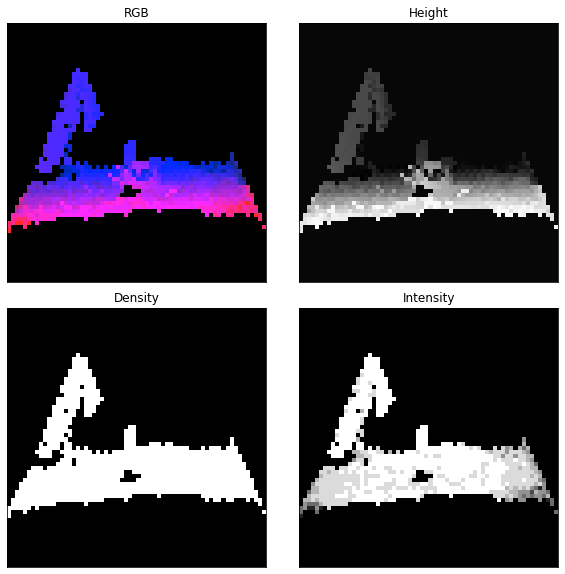

In [7]:
train_x, train_y = next(generator_rgbmaps_train)
print("Input-shape:", train_x.shape)
print("Output-shape:", train_y.shape)

from cgmcore.utils import show_rgb_map
show_rgb_map(train_x[0])

# Training-details.

Training-details are a dictionary that gets stored in a file after training. It is supposed to contain information that is valuable. For example data that is relevant for training including the hyper-parameters. Intended to be used when comparing different models.

In [8]:
training_details = {
    "dataset_path" : dataset_path,
    "qrcodes_train" : qrcodes_train,
    "qrcodes_validate" : qrcodes_validate,
    "steps_per_epoch" : steps_per_epoch,
    "validation_steps" : validation_steps,
    "epochs" : epochs,
    "batch_size" : batch_size,
    "random_seed" : random_seed,
}

# Training Net.

The module modelutils contains methods for creating Neural Nets. The following code shows how to instantiate and train a neural net on RGB-maps.

In [9]:
from cgmcore import modelutils

input_shape = (dataset_parameters_rgbmaps["rgbmap_target_width"], dataset_parameters_rgbmaps["rgbmap_target_height"], 3)
output_size = 1
model_dense = modelutils.create_dense_net(input_shape, output_size, hidden_sizes = [1024, 64])
model_dense.summary()
    
model_dense.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
    )

history = model_dense.fit_generator(
    generator_rgbmaps_train,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=generator_rgbmaps_validate,
    validation_steps=validation_steps
    )

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              12583936  
_________________________________________________________________
dense_2 (Dense)              (None, 64)                65600     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 12,649,601
Trainable params: 12,649,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4


InternalError: failed initializing StreamExecutor for CUDA device ordinal 0: Internal: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 16945512448

# Saving everything.

This saves the model, its history and the training-details to some output directory. The created artifacts can later be uses in order to compare different models.

In [ ]:
output_path = "."

modelutils.save_model_and_history(output_path, model_dense, history, training_details, "dense")